In [1]:
# ---
# Name: Autoencoder script
# Version: 0.1.0
# ---

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Import spectra dataset
data = pd.concat([pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/spectra_gen/ir-spectra-gen/data/IR_spectra/Broadened_IR_Spectra/2C9C_b3lyp_broadened_Gauessview_gamma_5_dx2.csv'),pd.read_csv('/Users/navin/Library/CloudStorage/Dropbox-AIZOTH/研究/Navin/spectra_gen/ir-spectra-gen/data/IR_spectra/Broadened_IR_Spectra/10C_b3lyp_broadened_Gauessview_gamma_5_dx2.csv')], axis = 0)

df = data.drop(columns = ['smiles'])

# Train-val-test split
X_train, X_val= train_test_split(df, test_size = 0.2)
X_val, X_test= train_test_split(X_val, test_size = 0.5)

print(df.columns)

# Standardize model
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# Convert to tensor
X_train_tensor = torch.tensor(X_train_s, dtype = torch.float32)
X_val_tensor = torch.tensor(X_val_s, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_s, dtype = torch.float32)

Index(['400', '402', '404', '406', '408', '410', '412', '414', '416', '418',
       ...
       '3982', '3984', '3986', '3988', '3990', '3992', '3994', '3996', '3998',
       '4000'],
      dtype='object', length=1801)


In [2]:
# Create dataloader
train_loader = DataLoader(X_train_tensor, batch_size= 32, shuffle = True)
val_loader = DataLoader(X_val_tensor, batch_size = 32)
test_loader = DataLoader(X_test_tensor, batch_size= 32)

# Define model
class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 50),
        )

        self.decoder = nn.Sequential(
            nn.Linear(50, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

model = AutoEncoder(input_dim=X_train_s.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)


In [3]:
best_val_loss =float('inf')
best_model_state = None

# train
for epoch in range(50):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        pred, _ = model(batch)
        loss = criterion(pred, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss/len(train_loader)
    print(f"Epoch {epoch+1}, training loss: {train_loss:.6f}")

    # val
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            pred, _ = model(batch)
            loss = criterion(pred, batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, val loss: {val_loss:.6f}")

    # save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state =  model.state_dict() # saves model weights

Epoch 1, training loss: 0.504633
Epoch 1, val loss: 0.482326
Epoch 2, training loss: 0.493270
Epoch 2, val loss: 0.453521
Epoch 3, training loss: 0.393232
Epoch 3, val loss: 0.398609
Epoch 4, training loss: 0.374970
Epoch 4, val loss: 0.596182
Epoch 5, training loss: 0.350874
Epoch 5, val loss: 0.357628
Epoch 6, training loss: 0.344321
Epoch 6, val loss: 0.356039
Epoch 7, training loss: 0.354703
Epoch 7, val loss: 0.402370
Epoch 8, training loss: 0.335192
Epoch 8, val loss: 0.354864
Epoch 9, training loss: 0.332626
Epoch 9, val loss: 0.340866
Epoch 10, training loss: 0.315930
Epoch 10, val loss: 0.346771
Epoch 11, training loss: 0.297665
Epoch 11, val loss: 0.296014
Epoch 12, training loss: 0.318334
Epoch 12, val loss: 0.378805
Epoch 13, training loss: 0.300919
Epoch 13, val loss: 0.301988
Epoch 14, training loss: 0.275732
Epoch 14, val loss: 0.536006
Epoch 15, training loss: 0.315143
Epoch 15, val loss: 0.344143
Epoch 16, training loss: 0.277635
Epoch 16, val loss: 0.290642
Epoch 17, 

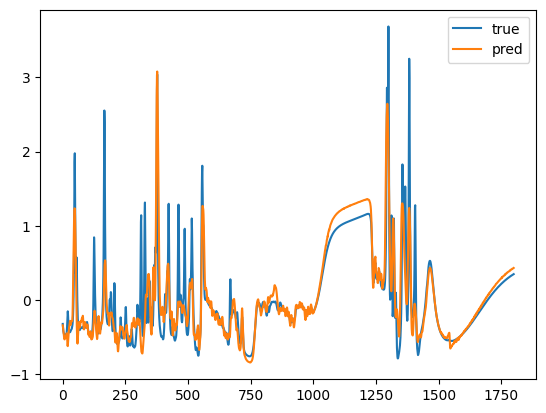

In [4]:
# test model
model.eval()
test_loss = 0
model.load_state_dict(best_model_state)

with torch.no_grad():
    for batch in test_loader:
        pred, _ = model(batch)
        break

# numpy it before lplotting
batch_np = batch.numpy()
pred_np = pred.numpy()

# Plot
import matplotlib.pyplot as plt

plt.plot(batch_np[6], label = 'true', linestyle = '-')
plt.plot(pred_np[6], label = 'pred', linestyle = '-')
plt.legend()
plt.show()